# 6 Kernel Methods

## 6.1. Dual representations

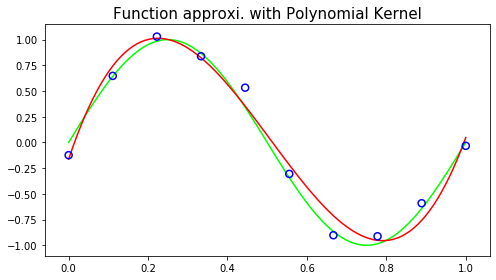

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import *

def create_noise_data(n_sample=10, std=0.1, margin=[0, 1]):
    x = np.linspace(*margin, n_sample)
    t = np.sin(2 * np.pi * x) + np.random.normal(scale=std, size=n_sample)
    return x, t

x_train, y_train = create_noise_data(n_sample=10)
x = np.linspace(0, 1, 100)
y_test = np.sin(2 * np.pi * x)

model = GP_regression(kernel=PolynomialKernel(3,1), beta=1e10)
model.fit(x_train, y_train)
y = model.predict(x)

fig = plt.figure(figsize=(7,4))
fig.add_subplot(111)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", label="noise", s=50, linewidth=1.5, zorder=3)
plt.plot(x, y_test, color="lime", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="prediction")
plt.title('Function approxi. with Polynomial Kernel', fontsize=15)
plt.tight_layout()
plt.show()

## 6.4. Gaussian Processes

One widely used kernel function for Gaussian process regression is given by the exponential of a quadratic form to give
<br><br>
$$
k(\boldsymbol{x}_n,\boldsymbol{x}_m)=\theta_0\exp\left\{-\frac{\theta_1}{2}\|\boldsymbol{x}_n-\boldsymbol{x}_m\|^2\right\}+\theta_2+\theta_3\boldsymbol{x}_n\cdot\boldsymbol{x}_m
$$
<br>
Conditional distribution $p(t_{N+1}|\boldsymbol{t})$ is a Gaussian distribution with mean and covariance given by
<br><br>
$$
\begin{align*}
m(x_{N+1})&=\boldsymbol{k}^{\mathrm{T}}\boldsymbol{C}^{-1}\boldsymbol{t}\\\\
\sigma^2(x_{N+1})&=\beta^{-1}+k(x_{N+1},x_{N+1})-\boldsymbol{k}^{\mathrm{T}}\boldsymbol{C}^{-1}\boldsymbol{k}
\end{align*}
$$
<br><br>
where covariance matrix $\boldsymbol{C}$ with elements given by $C_{nm}=k(\boldsymbol{x}_n,\boldsymbol{x}_m)+\beta^{-1}\delta_{nm}$ and $\boldsymbol{k}$ is a function of the test point input value $x_{N+1}$

## 6.4.2 Gaussian processes for regression

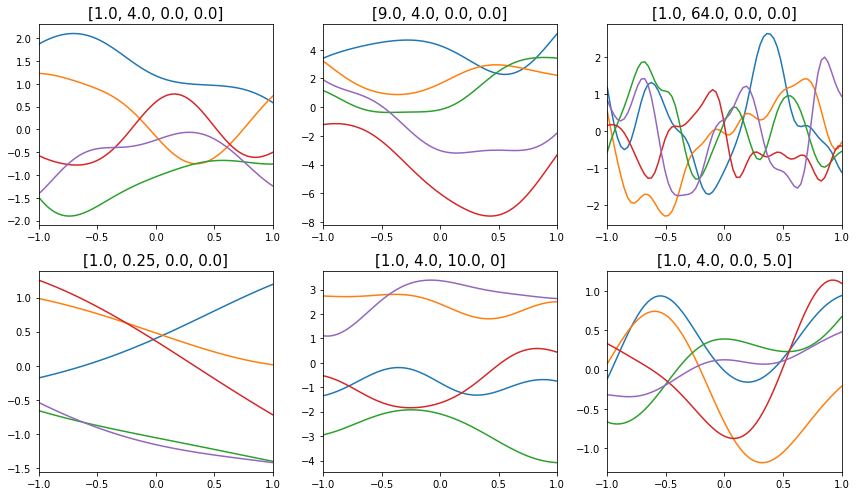

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import *

fig = plt.figure(figsize=(12,7))
div_num = 70
x = np.linspace(-1,1,div_num)
params = [[1.,4.,0.,0.],[9.,4.,0.,0.],[1.,64.,0.,0.],
          [1.,0.25,0.,0.],[1.,4.,10.,0],[1.,4.,0.,5.]]

for n, param in enumerate(params):
    fig.add_subplot(2,3,n+1)
    kernel = GaussianKernel(*param)
    model = GP_regression(kernel, beta=10.)
    model.fit(x,x,n_iter=0)
    for _ in range(1,6):
        gram = np.copy(model.Gram)
        y = np.random.multivariate_normal(np.zeros(div_num), gram, 1).ravel()
        plt.plot(x,y)
        plt.title('{}'.format(param),fontsize=15)
        plt.xlim([-1,1])
        plt.xticks(np.arange(-1,1.1,0.5),fontsize=10)
        plt.tight_layout()
plt.show()

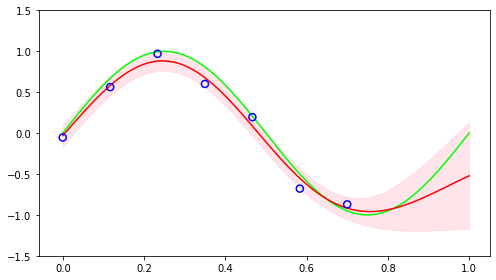

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import *

def create_noise(n_sample=10, std=0.1, margin=[0., 1.]):
    x = np.linspace(*margin, n_sample)
    t = np.sin(2 * np.pi * x) + np.random.normal(scale=std, size=n_sample)
    return x, t


''' Training & Test data '''
x_train, y_train = create_noise(n_sample=7, margin=[0, 0.7])
x_test = np.linspace(0, 1, 100)
y_test = np.sin(2 * np.pi * x_test)

''' Prediction '''
model = GP_regression(kernel=GaussianKernel(1,10), beta=100.)
model.fit(x_train, y_train)
y,y_std = model.predict(x_test, get_std=True)


# plotting prediction data
fig = plt.figure(figsize=(7,4))
fig.add_subplot(111)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, linewidth=1.5, zorder=3)
plt.plot(x_test, y_test, color="lime")
plt.plot(x_test, y, color="r")
plt.fill_between(x_test, y - y_std, y + y_std, alpha=0.4, color="pink", label="std")
plt.ylim([-1.5,1.5])
plt.tight_layout()
plt.show()

## 6.4.3 Learning the hyperparameters

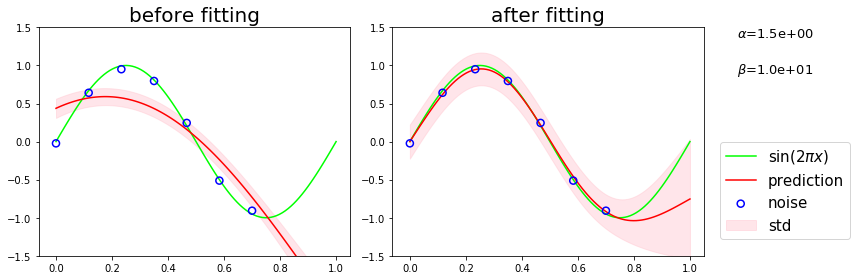

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import *

def make_noise(n_sample=10, std=0.1, margin=[0., 1.]):
    x = np.linspace(*margin, n_sample)
    t = np.sin(2 * np.pi * x) + np.random.normal(scale=std, size=n_sample)
    return x, t

x_train, y_train = make_noise(n_sample=7, margin=[0, 0.7])
x_test = np.linspace(0, 1, 100)
y_test = np.sin(2 * np.pi * x_test)

model = GP_regression(kernel=GaussianKernel(1,1), beta=100.)

fig=plt.figure(figsize=(12, 4))
for n,(max_iter,title) in enumerate(zip([0,1000],['before','after'])):
    ax = plt.subplot(1,2,n+1)
    model.fit(x_train, y_train, n_iter=max_iter)
    y,y_std = model.predict(x_test, get_std=True)
    ax.scatter(x_train, y_train, facecolor="none", edgecolor="b", label="noise", s=50, linewidth=1.5, zorder=3)
    ax.plot(x_test, y_test, color="lime", label="sin$(2\pi x)$")
    ax.plot(x_test, y, color="r", label="prediction")
    ax.fill_between(x_test, y - y_std, y + y_std, alpha=0.4, color="pink", label="std")
    ax.set_title(title + ' fitting', fontsize=20)
    ax.set_ylim([-1.5,1.5])
    
# optimized params
params = model.kernel.get_params()
ax.text(1.35,1,r"$\alpha$={:.1e}".format(params[0]),ha='right',va='top',transform=ax.transAxes,fontsize=13)
ax.text(1.35,0.85,r"$\beta$={:.1e}".format(params[1]),ha='right',va='top',transform=ax.transAxes,fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0, fontsize=15)
plt.tight_layout()
plt.show()

## 6.4.5 Gaussian processes for classification

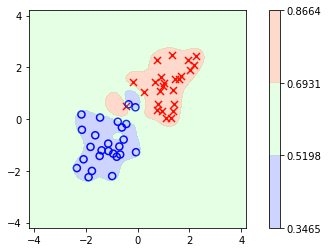

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import *

def generate_noise_data(n_sample):
    cov = [[0.5,0.2], [0.2,0.5]]
    N = int(n_sample // 2)
    cls1 = np.random.multivariate_normal([1.,1.], cov, N).T
    cls2 = np.random.multivariate_normal([-1.,-1.], cov, N).T
    t = np.hstack((np.ones(cls1.shape[1]),np.zeros(cls2.shape[1])))
    return cls1, cls2, t

cls1, cls2, t_train = generate_noise_data(50)
x_train = np.c_[cls1,cls2].T

X,Y = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
x_test = np.array([X.ravel(), Y.ravel()]).reshape(2,-1).T


model = GP_classifier(kernel=GaussianKernel(1.,7.))
model.fit(x_train, t_train)
Z = model.predict(x_test)

# plotting test data
plt.figure(figsize=(8,4))
plt.scatter(cls1[0],cls1[1],c='r',marker='x',label="class1",s=50,linewidth=1.5)
plt.scatter(cls2[0],cls2[1],facecolor="none", edgecolor="b",label="class2",s=50,linewidth=1.5)

# drawing prediction area
plt.contourf(X,Y, Z.reshape(X.shape), alpha=0.2, levels=np.linspace(min(Z), max(Z), 4),cmap='jet')
plt.colorbar()
plt.xlim(-4.2,4.2)
plt.ylim(-4.2,4.2)
plt.xticks(np.arange(-4,5,2))
plt.yticks(np.arange(-4,5,2))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()